In [41]:
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../")
from neighbor_map import Atoms
from ase.atoms import Atom

from ase.lattice.cubic import SimpleCubic, BodyCenteredCubic, FaceCenteredCubic, Diamond

def get_cutoff(atoms, n_neightbours, cutoff=10.):
    """Function to get the distance of n_th neighbour using matscipy neighbour list.

    """
    from matscipy.neighbours import neighbour_list

    i, d = neighbour_list("id", atoms, cutoff=cutoff)
    first_atom_d = d[i == 0]
    first_atom_d.sort()
    return first_atom_d[n_neightbours]

In [60]:
bulks = []
vacancies = []
interstitials = []

for lattice, symbol in zip([SimpleCubic, BodyCenteredCubic, FaceCenteredCubic, Diamond],
                            ["Po", "Fe", "Ni", "C"]):
    bulk = lattice(symbol, size=(4, 4, 4))
    bulks.append(Atoms(bulk))
    
    vacancy = bulk.copy()
    del vacancy[1]
    vacancies.append(Atoms(vacancy))

    interstitial = bulk.copy()
    interstitial.extend(Atom(symbol, (2.5, 2.5, 1.5)))
    interstitials.append(Atoms(interstitial))

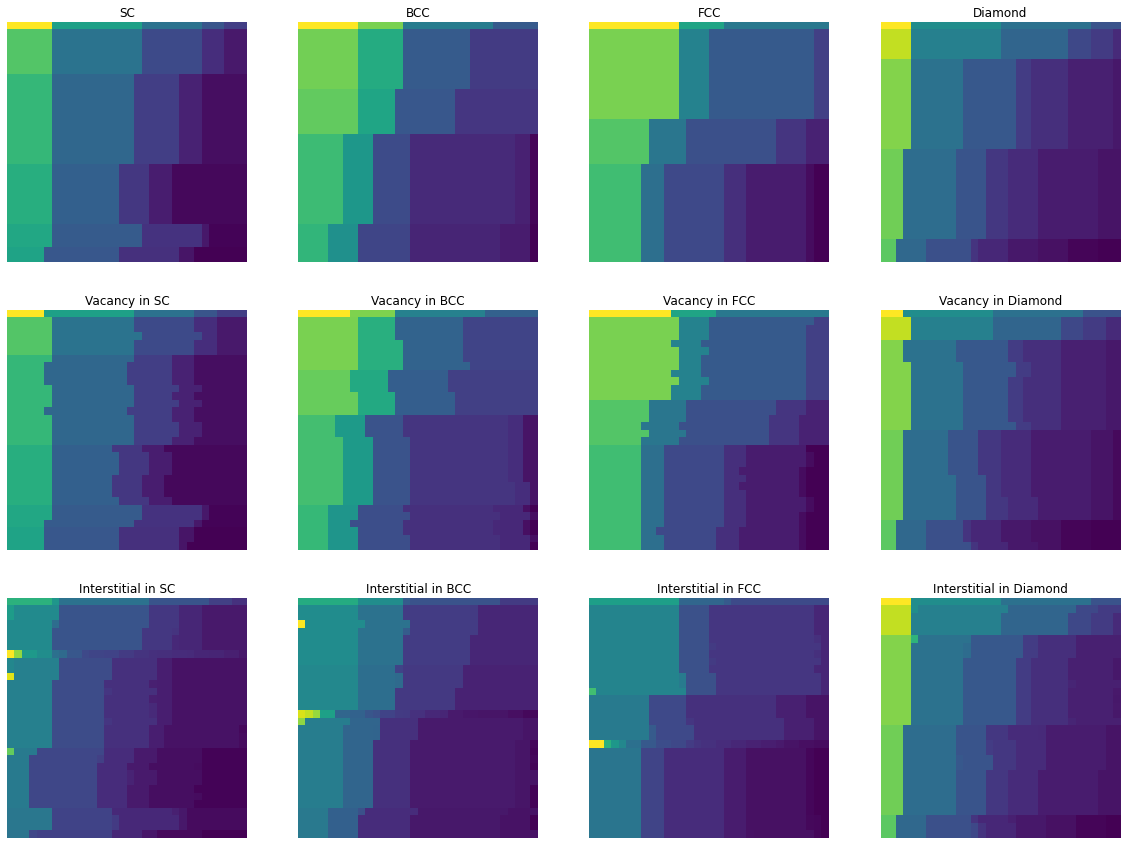

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

for structure, title, ax in zip(bulks,
                                ["SC", "BCC", "FCC", "Diamond"], axes[0]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title(title)
    ax.axis("off")

for structure, title, ax in zip(vacancies,
                                ["SC", "BCC", "FCC", "Diamond"], axes[1]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Vacancy in " + title)
    ax.axis("off")


for structure, title, ax in zip(interstitials,
                                ["SC", "BCC", "FCC", "Diamond"], axes[2]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Interstitial in " + title)
    ax.axis("off")

The preliminary outline of the tutorial:
- Introduction to neighbour maps as above (maybe more details about how it is constructed). Maybe add 3D interactive NGlView visualisations of atomic configurations?
- Training of the classifier on the on defects identified by Distortion Scores. Data should be provided in `data` folder. (Ask Sacha)
- Application to the MD data of the cascade. Ideally I should provide a MD simulation where C15 cluster is formed. Perhaps will need few cascades one after another. We should think how we then use the mapping: just a nice movie or extraction of physical data such as temperature of molten region etc.?

Do you think interactive plots could be helpful?